In [1]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import equilibriumfuns
from equilibriumfuns import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from equilibriumfuns import *
import cmath
#from helperfuns import *
fig_directory = '/Users/taliaborofsky/Documents/Stanford/Research/Feldman/Ecology_of_Learning/Pop Dynamics Social Learning/TeX_PopDyn/Figures_NoDelay'

# Helper Funs

In [7]:
#%%writefile helperfuns.py
import numpy as np
import pandas as pd
import scipy.stats as scs

# Helper functions
def Kfun(s, norm = scs.norm(0.2,1)):
    # Finds K, the probability of socially learning
    #input: d real positive numbe or -1, and a normmal curve
    #output K
    K = norm.cdf(s) - norm.cdf(-s)
    return(K)
# find pc given s and the normal curve
def pcfun(s, norm = scs.norm(0.2,1)):
    # Finds pc, the probability of individual learning correctly
    #input: d real positive numbe or -1, and a normmal curve
    #output pc
    pc = 1 - norm.cdf(s)
    return(pc)

# find pw given s and the normal curve
def pwfun(s,norm = scs.norm(0.2,1)):
    # Finds pw, the probability of individual learning incorrectly
    #input: d real positive numbe or -1, and a normmal curve
    #output pw
    pw = norm.cdf(-s)
    return(pw)


# The resource relative density recursion
def r_fun(r, N, u,beta, learn_r_u,learn_r_x, eta = 1):
    # The recursion for resource $i$
    x = 1 - u
    
    tot_learn_r = u*learn_r_u + x*learn_r_x
    r_next = r*(1 + eta - beta*N*tot_learn_r)/(1+eta*r)
    if r_next < 0:
        r_next = 0
        print('CP extinct')
    return(r_next)

# population size of predators in the next generation 
def PopSize(N_t,W,delta):
    # W is mean population fitness
    # delta is the death rate
    N_tplus1 = N_t*(W-delta)
    # to avoid runtime issues
    if N_tplus1 > 1E9:
        return(1E9)
    elif N_tplus1 <1E-9:
        return(0)
    else:
        return(N_tplus1)



def NextGen(u_r,u_R,x_r,x_R,N, r,R,beta,delta,K,pc,dk,dpc):
#    u_r,u_R = uvec
    u = u_r + u_R; x = 1 - u;
#    x_r,x_R = xvec
    p_r = u_r + x_r
    eta = 1
    
    learn_r_u = K*p_r + pc*(r/(r+R)) # no longer relevant - if r + R > 0 else K*p_r
    learn_r_x = (K+dk)*p_r + (pc+dpc)*(r/(r+R)) # no longer relevant - if r + R > 0 else (K+dk)*p_r
    
    Wu_r = u*learn_r_u*(1+r)
    Wu_R = u*(1-learn_r_u)*(1+R)
    #Wx_r = x*learn_r_x*(1+r)
    #Wx_R = x*(1-learn_r_x)*(1+R)
    W = Wu_r + Wu_R #+ Wx_r + Wx_R
    # need to check this with my eqn
    u_r = Wu_r/W
    u_R = Wu_R/W
    uvec_new = [u_r,u_R]
    #uvec_new = np.array([Wu_r,Wu_R])/W
    xvec_new = [0,0] # np.array([Wx_r,Wx_R])/W
    
    tot_learn_r = u*learn_r_u + x*learn_r_x
    r_next = r*(1 + eta - beta*N*tot_learn_r)/(1+eta*r)
    r_new = r_next if r_next > 0 else 0
    
    N_new = PopSize(N,W,delta)
    return(u_r,u_R, x_r,x_R,W,N_new, r_new)

def calculate_eq_r(K,pc,delta,R):
    # Calculates the nonzero r equilibrium
    
    if R>delta:
        return(np.NaN)
    
    a = pc + K*(delta-R)/(1+delta)
    b = (delta-R)*(K*(1+R)/(1+delta) -1) - R*pc
    c = -R*(delta-R)*(1-K/(1+delta))
    if b**2 - 4*a*c > 0:
        return((-b + np.sqrt(b**2 - 4*a*c))/(2*a))
    else:
        return(np.NaN)

def GetXsteps(param_grid, tsteps):
    u_r_init = param_grid.u_r_init.values
    r_init = param_grid.r_init.values
    
def iterate_row(row,tsteps):
    # iterates from the initial point. tsteps generations
    # row could also be a dataframe
    u_r = row.u_r_init.values
    u_R = 1 - u_r
    r = row.r_init.values
    n = r.size
    x_r = np.zeros(n)
    x_R = np.zeros(n)
    N = row.N_init.values
    R = row.R.values
    beta = row.beta.values; delta = row.delta.values
    K = row.K.values; pc = row.pc.values
    NextGenV = np.frompyfunc(NextGen,13,7)
    for t in range(1,tsteps):
        out = NextGenV(u_r,u_R,x_r,x_R,N,r,R,beta,delta,K,pc,0,0)
        u_r, u_R, x_r,x_R,W,N, r = np.array(list(out),dtype=float)
    row.u_r_eq = u_r
    row.r_eq = r
    row.N_eq = N
    row.W_eq = W
    return(row)

def get_trajectory(u_r,u_R,x_r,x_R,N,r,R,beta,delta,K,pc,tsteps, dk = 0, dpc = 0):
    # TO-DO: Check this works!!!
    u_r_vec = np.zeros(tsteps); u_r_vec[0] = u_r
    u_R_vec = np.zeros(tsteps); u_R_vec[0] = u_R
    x_r_vec = np.zeros(tsteps); x_r_vec[0] = x_r
    x_R_vec = np.zeros(tsteps); x_R_vec[0] = x_R
    N_vec = np.zeros(tsteps); N_vec[0] = N;
    r_vec = np.zeros(tsteps); r_vec[0] = r;
    NextGenV = np.frompyfunc(NextGen,13,7)
    for t in range(1,tsteps):
        out = NextGenV(u_r,u_R,x_r,x_R,N,r,R,beta,delta,K,pc,dk,dpc)
        u_r, u_R, x_r, x_R, W, N, r = np.array(list(out), dtype=float)
        u_r_vec[t], u_R_vec[t], x_r_vec[t], x_R_vec[t], N_vec[t], r_vec[t] = u_r, u_R, x_r, x_R, N, r
    return(u_r_vec, u_R_vec, x_r_vec, x_R_vec, N_vec, r_vec, W)
    
    
    

# Equilibrium Funs

In [8]:
%%writefile equilibriumfuns.py

import numpy as np
import pandas as pd
import scipy.stats as scs
import helperfuns
from helperfuns import *
from numpy.lib.scimath import sqrt as csqrt
import cmath


def get_r_hat(K,pc,delta,R):
    a = pc + K*(delta-R)/(1+delta)
    b = (delta-R)*(K*(1+R)/(1+delta)-1) - R*pc
    c = -R*(delta-R)*(1 - K/(1+delta))
    
    
    discrim = b**2 - 4*a*c
    rpos = 0
    rneg = 0
    if discrim >= 0:
        rpos = (-b + np.sqrt(b**2 - 4*a*c))/(2*a) 
        rneg = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
        if R < delta:
            rpos_ans = rpos if rpos < 1 and rpos >= delta else np.nan
            rneg_ans=np.nan
        if R > delta:
            rpos_ans = rpos if rpos > 0 and rpos <= delta else np.nan
            rneg_ans = rneg if rneg > 0 and rneg <= delta else np.nan
        if R== delta:
            rpos_ans = R if R > 0 else np.nan
            rneg_ans = np.nan
    else:
        rpos_ans = np.nan
        rneg_ans = np.nan

    return(np.array([rpos_ans,rneg_ans]))
# Finds the nonzero r equilibrium if it exists
# inputs must be arrays with the same dimensions
def get_r_hat_v(K, pc, delta, R):
    
    K,pc,delta,R = [np.array(item) for item in [K,pc,delta,R]]
    #rpos = np.zeros(K.shape)
    #rneg = np.zeros(K.shape)
    
    a = pc + K*(delta-R)/(1+delta)
    b = (delta-R)*(K*(1+R)/(1+delta)-1) - R*pc
    c = -R*(delta-R)*(1 - K/(1+delta))
    discrim = b**2 - 4*a*c
    
    rpos = np.array((-b + csqrt(b**2 - 4*a*c))/(2*a))
    rneg = (-b - csqrt(b**2 - 4*a*c))/(2*a)
    
    rpos_ans = np.zeros(rpos.shape)
    rneg_ans = np.zeros(rneg.shape)
    
    mask1a = ((discrim>=0) & (rpos >0))& ((rpos <=delta)& (R>delta))
    mask1b = ((discrim>=0) & (rpos >0))& ((rpos >=delta)& (R<delta))
    rpos_ans[mask1a] = rpos[mask1a].real # these are real numbers anyways with 0 in the imaginary part, 
    # but this gets rid of the complex casting warning
    rpos_ans[mask1b] = rpos[mask1b].real
    
    mask2a = ((discrim>=0) & (rneg >0))& ((rneg <=delta)&(R>delta))
    mask2b = ((discrim>=0) & (rneg >0))& ((rneg >=delta)&(R<delta))
    rneg_ans[mask2a]=rneg[mask2a].real 
    rneg_ans[mask2b]=rneg[mask2b].real
    
    
    return(rpos_ans, rneg_ans)
# Finds the u_r equilibrium for the r that solves r = 1 - beta*N*L, if it exists
# works if delta \neq R
def get_u_hat(r,delta,R):
    # note need r > 0\ 
    if r==R:
        print('we have a problem. r = R.')
        # either N_p = 0 or R = delta
        if R == delta:
            return(np.nan)
    if R == delta:
        print('we have a problem. R = delta.')
    W = 1 + R + (r-R)
    L = (delta-R)/(r-R)
    u_r = L*(1+r)/(1+delta)
    
    return(u_r)

def get_N_hat(r,delta,R,beta):
    N = (1-r)*(r-R)/(beta*(delta-R))
    return(N)

# this should be 1 + delta if r > 0
#def get_W_hat(r,delta,R)

def get_Jstar_lambdas(r,u,N,K,pc,beta, delta,R):
    # J = ((W-delta,a,b), (0,c,d), (e,f,g))
    # rows and columns: dn, du, dr
    #(1,a,b) from Eq. 37 (the equation for delta_N')
    # (0,c,d) from Eq. 38 (the equation for delta_u_r')
    # (e,f,g) from Eq. 39 (the equation for delta_r')
    
    L = K*u + pc*r/(r+R)
    W = 1 + R + (r-R)*L
    a = N*K
    b = N*(L + R*pc*(r-R)/((r+R)**2))
    c = (K/(W))*(1+r-u)
    d = (L/(W))*(1-u) + (pc*R/(W*(r+R)**2))*(1+r-u*(r-R))
    e = -r*beta*L/(1+r)
    f = -K*N*r*beta/(1+r)
    g = 1/(1+r) - N*r*beta*R*pc/((1+r)*(r+R)**2)
    
    xi1 = -c -g -1
    xi2 = b*e - c*g - c + d*f - g
    xi3 = -a*d*e + b*c*e - c*g + d*f
    xi4 = cmath.sqrt(-4*(3*xi2 + xi1**2)**3 + (27*xi3 + 9*xi1*xi2 + 2*xi1**3)**2)
    xi5 = np.cbrt((27/2)*xi3 + (1/2)*xi4 + (9/2)*xi1*xi2 + xi1**3)
    lambda1 = (-1/3)*(xi1 + (3*xi2 + xi1**2)/xi5 + xi5)

    vcomplex = np.vectorize(complex)
    lambda2 = vcomplex((1/3)*(xi1 + (3*xi2+xi1**2)/(2*xi5) + xi5/2),
                                   (np.sqrt(3)/6)*((3*xi2+xi1**2)/xi5 - xi5))
    lambda3 = vcomplex((1/3)*(xi1 + (3*xi2+xi1**2)/(2*xi5) + xi5/2),
                                   -(np.sqrt(3)/6)*((3*xi2+xi1**2)/xi5 - xi5))
    
    return([lambda1, lambda2, lambda3])

# gets the internal stability given parameters and r
def get_internal_stability(r,beta,K,pc,delta,R):
    if r == np.nan:
        return(np.nan)
    N = get_N_hat(r,delta,R,beta)
    #TO-DO: What if delta = R???
    u = get_u_hat(r,delta,R)
    lambdas = get_Jstar_lambdas(r,u,N,K,pc,beta, delta,R)
    mags = np.abs(lambdas)
    if np.max(mags)>1:
        return(0)
    elif np.max(mags) < 1:
        return(1)
    else:
        return(-1)




Overwriting equilibriumfuns.py


# Check 1

In [76]:
delta = 0.2
R = 0.1
s = 1
mu = 0
beta = 0.01
N_init = 100

u_r_vals = np.array([0.01,0.2,0.45,0.7,0.98])
# u_R_vals = 1 - u_r_vals
r_init_vals = np.array([0.05, 0.1, 0.48, 0.7, 0.99 ])

u_mesh, r_mesh = np.meshgrid(u_r_vals, r_init_vals)
u_vec = np.ndarray.flatten(u_mesh)
r_vec = np.ndarray.flatten(r_mesh)
n = r_vec.size
df1 = pd.DataFrame(data={'u_r_init':u_vec, 'r_init': r_vec, 'N_init':N_init, 'R':R, 'beta':beta,
                        'delta':delta, 'mu': mu, 's': s, 'K': Kfun(s,scs.norm(mu)), 'pc': pcfun(s,scs.norm(mu)),
                        'u_r_eq':np.zeros(n), 'r_eq':np.zeros(n), 'N_eq':np.zeros(n), 'W_eq':np.zeros(n)})

In [77]:
row = pd.DataFrame(data={'u_r_init':0.5, 'r_init': 1, 'N_init':100, 'R':R, 'beta':.01,
                        'delta':delta, 'mu': mu, 's': s, 'K': Kfun(s,scs.norm(mu)), 'pc': pcfun(s,scs.norm(mu)),
                        'u_r_eq':0, 'r_eq':0, 'N_eq':0, 'W_eq':0},index=[0])

In [85]:
iterate_row(df1,1000)

,u_r_init,r_init,N_init,R,beta,delta,mu,s,K,pc,u_r_eq,r_eq,N_eq,W_eq
0,0.01,0.05,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
1,0.20,0.05,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
2,0.45,0.05,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
3,0.70,0.05,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
4,0.98,0.05,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
5,0.01,0.10,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
6,0.20,0.10,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
7,0.45,0.10,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
8,0.70,0.10,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2
9,0.98,0.10,100,0.1,0.01,0.2,0,1,0.682689,0.158655,0.516885,0.311432,145.585261,1.2


In [86]:
get_r_hat_vec = np.frompyfunc(get_r_hat,4,1)
get_r_hat_vec(df1.K.values,df1.pc.values,df1.delta.values,df1.R.values)

array([array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan]), array([0.3114319,       nan]),
       array([0.3114319,       nan])], dtype=object)

# Check 2

In [21]:
#NextGen(u_r,u_R,x_r,x_R,N, r,R,beta,delta,K,pc,dk,dpc)
NextGenV = np.frompyfunc(NextGen,13,7)

In [22]:
out = NextGenV(u_vec, 1 - u_vec, np.zeros(len(u_vec)),np.zeros(len(u_vec)), 
               N_init,r_vec, R, beta, delta, Kfun(s,scs.norm(mu)),pcfun(s,scs.norm(mu)), 0, 0)

In [94]:
u_r_vals = [0.01,0.2,0.45,0.7,0.98]
# u_R_vals = 1 - u_r_vals
r_init_vals = [0.05, 0.1, 0.48, 0.7, 0.99 ]
R_vals = [0.01, 0.25, 0.55, 0.9]
N_init = [10,50,100,150]
beta_vals = [0,0.005,0.01] # chosen so that r = 1 - beta*N*L >= 0 if L = 1, N <=100.
delta_vals = [0.02, 0.3, 0.8]
mu_vals = [-1,0,1]
s_vals = [0,1,3]
u_mesh, r_mesh, N_mesh, R_mesh, beta_mesh, delta_mesh, mu_mesh, s_mesh = np.meshgrid(u_r_vals, r_init_vals, N_init, R_vals, 
                                                                             beta_vals, delta_vals, mu_vals, s_vals)
u_r_vec, r_vec, N_vec, R_vec, beta_vec, delta_vec, mu_vec, s_vec = [np.ndarray.flatten(mat) for mat in [u_mesh,r_mesh, N_mesh,
                                                                                               R_mesh, beta_mesh, 
                                                                                               delta_mesh, mu_mesh, 
                                                                                               s_mesh]]
u_R_vec = 1 - u_r_vec
Kvec = Kfun(s_vec, scs.norm(mu_vec))
pcvec = pcfun(s_vec, scs.norm(mu_vec))
n = len(Kvec)
df = pd.DataFrame(data = {'u_r_init': u_r_vec, 'r_init': r_vec, 'N_init':N_vec,'R':R_vec, 'beta':beta_vec, 
                          'delta':delta_vec, 'mu':mu_vec, 's':s_vec, 'K': Kvec, 'pc':pcvec,
                         'u_r_eq':np.zeros(n), 'r_eq':np.zeros(n), 'N_eq':np.zeros(n), 'W_eq':np.zeros(n)})

In [96]:
df_try = df.sample(10)

In [165]:
df_out = iterate_row(df_try,100000)

In [166]:
df_out_reached_eq = df_out.query('W_eq-1 - delta > -0.0000000001 & W_eq-1 - delta < 0.0000000001')

In [167]:
df_out_reached_eq

,u_r_init,r_init,N_init,R,beta,delta,mu,s,K,pc,u_r_eq,r_eq,N_eq,W_eq
18177,0.98,0.48,10,0.01,0.005,0.02,1,0,0.00000,0.841345,0.613963,0.026390,319.143017,1.02
25106,0.98,0.70,50,0.25,0.010,0.80,0,3,0.99730,0.001350,0.996227,0.803005,19.807151,1.80
14821,0.20,0.48,50,0.55,0.010,0.80,1,1,0.47725,0.500000,0.696246,0.936247,9.849717,1.80
13338,0.01,0.48,50,0.01,0.010,0.02,-1,0,0.00000,0.158655,0.149607,0.080828,651.029228,1.02


In [168]:
K,pc,delta,R= np.transpose(df_out_reached_eq[["K","pc","delta","R"]].values)
result = get_r_hat_vec(K,pc,delta,R)

In [169]:
np.transpose(np.array(list(result)))

array([[0.02638967, 0.80300468, 0.93624735, 0.08082777],
       [       nan,        nan,        nan,        nan]])

In [157]:
df_out_reached_eq[["K","pc","delta","R"]]

,K,pc,delta,R
18177,0.00000,0.841345,0.02,0.01
25106,0.99730,0.001350,0.80,0.25
14821,0.47725,0.500000,0.80,0.55
13338,0.00000,0.158655,0.02,0.01


# Is social learning beneficial?

# Extinction of Predators

Here, I want to see under which conditions predators will go extinct

In [9]:
def plot_colourline(x,y,c,minc=None,maxc=None, ax=None, cmapAnchor = True, cmap = None, add_arrow = True,hl=20,hw=20):
    if minc == None:
        minc = np.min(c)
        maxc = np.max(c)
        #ptpc = np.ptp(c)
    c_orig = c  
    if cmap == None:
        c = cm.viridis((c-minc)/(maxc-minc))
    else:
        c = cmap((c-minc)/(maxc-minc))

    
    if ax == None:
        ax = plt.gca()
    # set up a scatter plot and clear it just so I have something to feed the colorbar thing
    if cmapAnchor:
        CS3 = ax.scatter(x,y,c=c)
        ax.cla()
    else:
        CS3 = None
    lw = 3.0
    for i in np.arange(len(x)-1):
        
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=c[i],linewidth=lw)
    if add_arrow==True:

        ax.quiver(x[0],y[0],x[1] - x[0],y[1] - y[0],
                  scale_units='xy', angles='xy', scale=1,color=c[1],
                  width=lw/500, headwidth=hw, headlength=hl)
        ax.quiver(x[2],y[2],x[3] - x[2],y[3] - y[2],
                  scale_units='xy', angles='xy', scale=1,color=c[1],
                  width=lw/500, headwidth=hw, headlength=hl)

        
    return(CS3)

Above I tried to have points colored by the u_r value. However, this seems too confusing.

In [12]:
def plot_Nru_traj(ax, R,delta,mu,s,beta,tsteps, cmap, minu=0, maxu=1, Nvals = [100,100,100,100],hl=20,hw=20, 
                  rvals = [0.2, 0.8, 0.5, 0.3], uvals = [0.1, 0.5, 0.2, 0.9]):
    K = Kfun(s,scs.norm(mu))
    pc = pcfun(s,scs.norm(mu))
    

    x_r=0; x_R=0
    # get trajectories
    trajs = [get_trajectory(u_r, 1 - u_r, x_r,x_R,N,r,R,beta,delta,K,pc,tsteps) for u_r, r,N in zip(uvals, rvals,Nvals)]
    u_r_vecs = [traj[0] for traj in trajs]
    N_vecs = [traj[4] for traj in trajs]
    r_vecs = [traj[-2] for traj in trajs]
    # plot
    for i in range(0,len(uvals)):
        r_vec = r_vecs[i]
        N_vec = N_vecs[i]
        cs = plot_colourline(r_vec,N_vec,u_r_vecs[i],minc=minu,maxc=maxu,ax=ax, cmapAnchor=False, cmap = cmap,hl=hl,hw=hw)
    rhats,Nhats, uhats = get_equilibrium_data(K,pc,delta,R)
    
    for i,r in enumerate(rhats):
        if np.isnan(r)==False:
            uhat = uhats[i]
            Nhat = Nhats[i]
            ax.scatter(r,Nhat,color=cmap((uhat-minu)/(maxu-minu)), s=500, marker='*')
    return(trajs,rhats)

#     rhats,Nhats, uhats, lambdamat,magsmat,stabilities = get_equilibrium_data(K,pc,delta,R)
    
#     for i,r in enumerate(rhats):
#         if np.isnan(r)==False:
#             uhat = uhats[i]
#             Nhat = Nhats[i]
#             stability = stabilities[i]
#             ucolor = cmap((uhat-minu)/(maxu-minu))
#             face_color = ucolor if stability==1 else 'none'
#             #ax.scatter(r,Nhat,color=cmap((uhat-minu)/(maxu-minu)), s=500, marker='*')
#             ax.scatter(r,Nhat,facecolors = face_color, edgecolors=ucolor, s=500, marker='*')
    
#     return(trajs,rhats,lambdamat,magsmat)

def get_equilibrium_data(K,pc,delta,R):
    rhats = get_r_hat(K,pc,delta,R)
#     lambdamat = [[],[]]
#     magsmat = [[],[]]
#     stabilities = [0,0]
    Nhats = [0,0]
    uhats = [0,0]
    for i,r in enumerate(rhats):
        if np.isnan(r) == False:
            N = get_N_hat(r,delta,R,beta)
            u = get_u_hat(r,delta,R)
#             lambdas = get_Jstar_lambdas(r,u,N,K,pc,beta,delta,R)
#             mags = np.abs(lambdas)
            
            Nhats[i] = N
            uhats[i]=u
    return(rhats,Nhats,uhats)
#             lambdamat[i] = lambdas
#             magsmat[i] = mags
#             stabilities[i] = max(mags)<1
#     return(rhats,Nhats, uhats, lambdamat,magsmat,stabilities)

        

<ipython-input-58-2fcb8e355c51>:47: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = fig.colorbar(cb_anchor)
<ipython-input-58-2fcb8e355c51>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(yticklabs)


Text(0.5, 1.0, '$R=$0.10, $\\delta=$0.20, $\\mu = $-0.5, $s =$1, $\\beta=$ 0.10, ')

<Figure size 432x288 with 0 Axes>

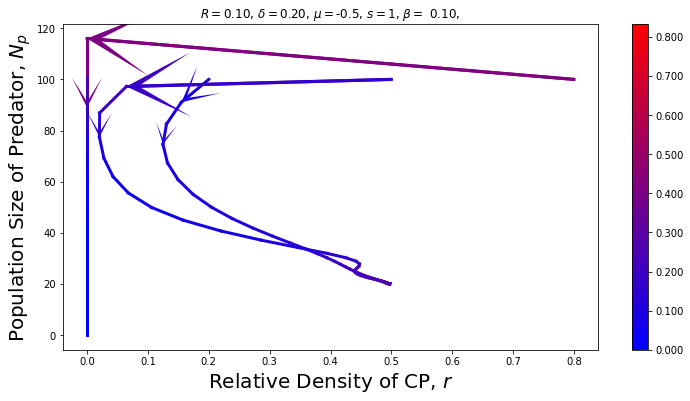

In [58]:
beta = 0.1
delta = 0.2
mu = -0.5
R = 0.1
s = 1
K = Kfun(s,scs.norm(mu))
pc = pcfun(s,scs.norm(mu))

N=100
rvals = [0.2, 0.8, 0.5]
uvals = [0.1, 0.5, 0.2]
tsteps = 1000

trajs = [get_trajectory(u_r, 1 - u_r, 0,0,N,r,R,beta,delta,K,pc,tsteps) for u_r, r in zip(uvals, rvals)]
u_r_vecs = [traj[0] for traj in trajs]
N_vecs = [traj[4] for traj in trajs]
r_vecs = [traj[-2] for traj in trajs]





# need something to feed the colorbar
all_u = np.ndarray.flatten(np.array(u_r_vecs))
all_N = np.ndarray.flatten(np.array(N_vecs))
all_r = np.ndarray.flatten(np.array(r_vecs))

minu = all_u.min()
maxu = all_u.max()+.1

mymap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
cb_anchor = plt.imshow((np.array(u_r_vecs) - minu)/(maxu-minu),cmap=mymap)

plt.clf()

# set up plot
fig, ax = plt.subplots(1,1, figsize = [12,6])

minu = 0; maxu = 1
for i in range(0,3):
    r_vec = r_vecs[i]
    N_vec = N_vecs[i]
    cs = plot_colourline(r_vec,N_vec,u_r_vecs[i],minc=minu,maxc=maxu,ax=ax, cmapAnchor=False, cmap = mymap)


# set up colorbar
cb = fig.colorbar(cb_anchor)

yticks_cb = cb.ax.get_yticks()
yticks = yticks_cb*(maxu-minu) + minu
yticklabs = ['%0.3f'%tick for tick in yticks]
cb.ax.set_yticklabels(yticklabs)

ax.set_ylabel(r'Population Size of Predator, $N_p$', fontsize = 20)
ax.set_xlabel(r'Relative Density of CP, $r$', fontsize = 20)

ax.set_title(r'$R=$%.2f, $\delta=$%.2f, $\mu = $%.1f, $s =$%d, $\beta=$ %.2f, ' %(R,delta, mu,s, beta))

[0.49695153        nan]


<ipython-input-134-f4ed38cb75b2>:21: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = fig.colorbar(CS)


Text(0.5, 1.0, '$u_r$')

<Figure size 432x288 with 0 Axes>

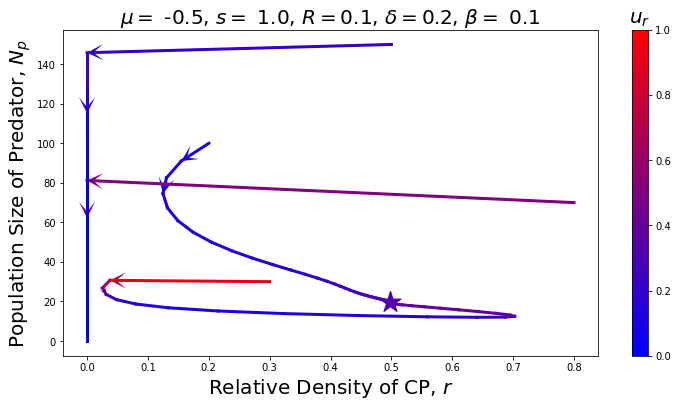

In [134]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
tsteps = 100
beta = 0.1
delta = 0.2
mu = -0.5
R = 0.1
s = 1.0


#make colorbar anchor
a = np.linspace(0,1,20)
b = np.linspace(0,1,20)
np.outer(a,b)
CS = plt.imshow(np.outer(a,b), cmap = cmap)
plt.clf()

fig, ax = plt.subplots(1,1, figsize = [12,6])
trajs = plot_Nru_traj(ax, R,delta,mu,s,beta,tsteps, cmap, minu=0, maxu=1, Nvals = [100,70,150,30])
ts = r'$\mu=$ %.1f, $s=$ %.1f, $R=$%.1f, $\delta=$%.1f, $\beta =$ %.1f' %(mu,s,R,delta, beta)
ax.set_title(ts, fontsize = 20)


cb = fig.colorbar(CS)
cb.ax.set_title(r'$u_r$', fontsize=20)

## Plotting trajectories for $R < \delta$

### $\beta = 0.1, \delta = 0.2, R = 0.1$

<Figure size 432x288 with 0 Axes>

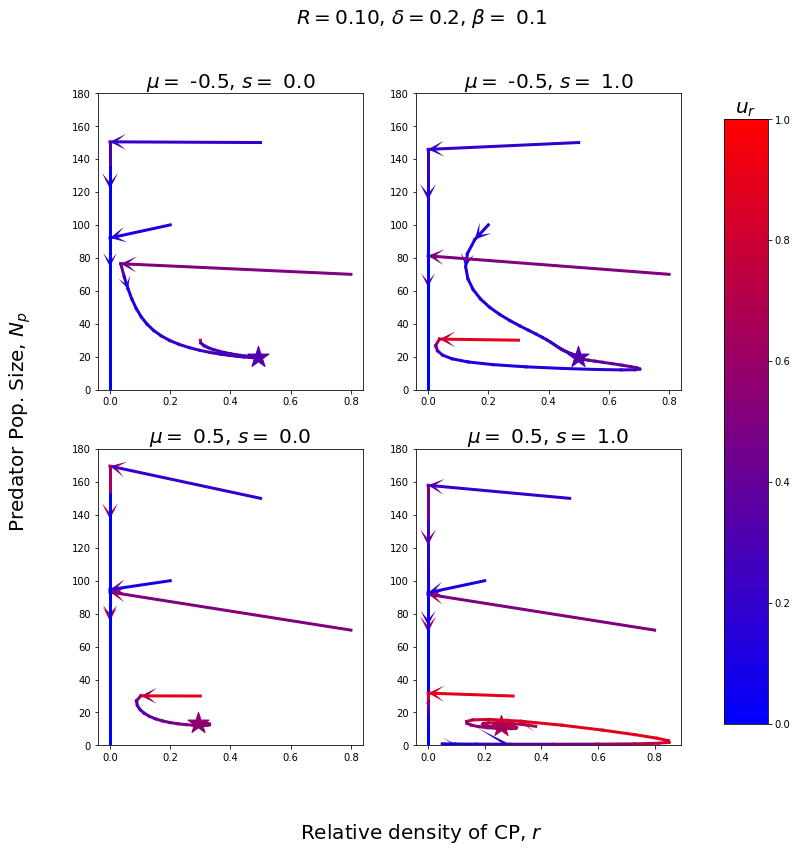

In [14]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
tsteps = 500
beta = 0.1
delta = 0.2
#mu = -0.5
R = 0.1


#make colorbar anchor
a = np.linspace(0,1,20)
b = np.linspace(0,1,20)
np.outer(a,b)
CS = plt.imshow(np.outer(a,b), cmap = cmap)
plt.clf()

fig, axs = plt.subplots(2,2, figsize = [12,12])
muvals = [-0.5,-0.5,0.5,0.5]
svals = [0,1,0,1]
for i, ax in enumerate(axs.flatten()):
    mu = muvals[i]
    s=svals[i]
    #trajs, rhats,lambdas,mags = plot_Nru_traj(ax, R,delta,mu,s,beta,tsteps, cmap, minu=0, maxu=1, Nvals = [100,70,150,30],hl=10,hw=10)
    trajs, rhats = plot_Nru_traj(ax, R,delta,mu,s,beta,tsteps, cmap, minu=0, maxu=1, Nvals = [100,70,150,30],hl=10,hw=10)
#     print(r'$\hat{r}$')
#     print(rhats)
#     print(r'$\lambda$')
#     print(lambdas)
#     print(r'$|\lambda|$')
#     print(mags)
    
    ts = r'$\mu=$ %.1f, $s=$ %.1f' %(mu,s)
    ax.set_title(ts, fontsize = 20)
    ax.set_ylim([0,180])

    
# need to add a trajectory to last plot
K = Kfun(s,scs.norm(mu)); pc = pcfun(s,scs.norm(mu))
rhat = get_r_hat(K,pc,delta,R)[0]
Nhat = get_N_hat(rhat,delta,R,beta)
uhat = get_u_hat(rhat,delta,R)

r = .38
N = Nhat
u_r = uhat;
x_r = 0; x_R = 0
traj = get_trajectory(u_r, 1 - u_r, x_r,x_R,N,r,R,beta,delta,K,pc,tsteps)
u_r_vec, u_R_vec, x_r_vec, x_R_vec, N_vec, r_vec, W = traj
cs = plot_colourline(r_vec,N_vec,u_r_vec,minc=0,maxc=1,ax=ax, cmapAnchor=False, cmap = cmap,hl=20,hw=20)

# add another trajectory close to E0
r = 0.05
N = 1
u_r = 0.05
traj = get_trajectory(u_r, 1 - u_r, x_r, x_R, N, r, R, beta, delta, K, pc, tsteps)
u_r_vec, u_R_vec, x_r_vec, x_R_vec, N_vec, r_vec, W = traj
cs = plot_colourline(r_vec,N_vec,u_r_vec,minc=0,maxc=1,ax=ax, cmapAnchor=False, cmap = cmap,hl=20,hw=20)



fig.supxlabel('Relative density of CP, $r$', fontsize = 20)
fig.supylabel('Predator Pop. Size, $N_p$', fontsize = 20)
ts = r'$R=$%.2f, $\delta=$%.1f, $\beta =$ %.1f' %(R,delta,beta)
fig.suptitle(ts, fontsize = 20)
# colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
cb = fig.colorbar(CS, cax = cbar_ax)
cb.ax.set_title(r'$u_r$', fontsize=20)
fig.savefig(fig_directory + '/Trajectories_R01_delta02_beta01.jpg',dpi=600)

### $\beta = 0.05, \delta = 0.2, R = 0.1$

 r equilibria
[0.49022424        nan]
eigenvalues
[[3.700743415417188e-17, array(-0.26884706-0.10650667j), array(-0.26884706+0.10650667j)], []]
magnitude of eigenvalues
[array([3.70074342e-17, 2.89175395e-01, 2.89175395e-01]), []]
 r equilibria
[0.49695153        nan]
eigenvalues
[[0.7400486154839389, array(-0.7650064-0.28235392j), array(-0.7650064+0.28235392j)], []]
magnitude of eigenvalues
[array([0.74004862, 0.81544989, 0.81544989]), []]
 r equilibria
[0.29383881        nan]
eigenvalues
[[7.401486830834377e-17, array(-0.27238539-0.25132015j), array(-0.27238539+0.25132015j)], []]
magnitude of eigenvalues
[array([7.40148683e-17, 3.70615186e-01, 3.70615186e-01]), []]
 r equilibria
[0.25602483        nan]
eigenvalues
[[0.5419904502886781, array(-0.6606455-0.40536038j), array(-0.6606455+0.40536038j)], []]
magnitude of eigenvalues
[array([0.54199045, 0.77509323, 0.77509323]), []]


<Figure size 432x288 with 0 Axes>

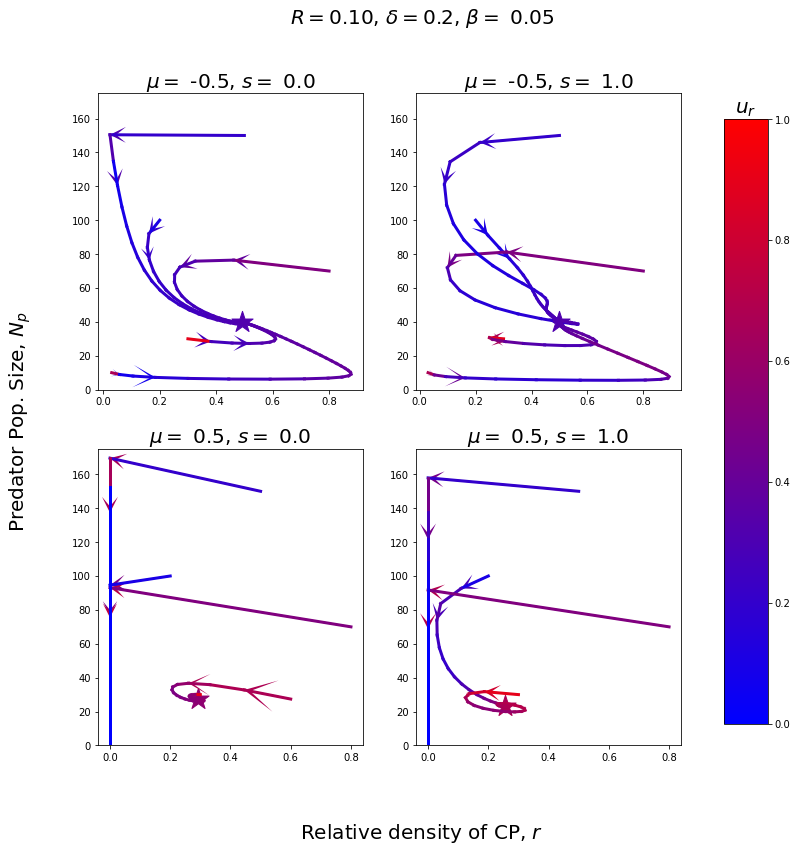

In [103]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
tsteps = 500
beta = 0.05
delta = 0.2
#mu = -0.5
R = 0.1
#s = 1.0


#make colorbar anchor
a = np.linspace(0,1,20)
b = np.linspace(0,1,20)
np.outer(a,b)
CS = plt.imshow(np.outer(a,b), cmap = cmap)
plt.clf()

fig, axs = plt.subplots(2,2, figsize = [12,12])
muvals = [-0.5,-0.5,0.5,0.5]
svals = [0,1,0,1]

for i, ax in enumerate(axs.flatten()):
    mu = muvals[i]
    s=svals[i]
    
    trajs,rhats,lambdas,mags = plot_Nru_traj(ax, R,delta,mu,s,beta,tsteps, cmap, minu=0, maxu=1, Nvals = [100,70,150,30],hl=10,hw=10)
    ts = r'$\mu=$ %.1f, $s=$ %.1f' %(mu,s)
    ax.set_title(ts, fontsize = 20)
    ax.set_ylim([0,175])
    if i<2:
        K = Kfun(s,scs.norm(mu)); pc = pcfun(s,scs.norm(mu))
        r = 0.03; N = 10; u = .98; x_r = 0; x_R = 0
        traj = get_trajectory(u_r, 1 - u_r, x_r,x_R,N,r,R,beta,delta,K,pc,tsteps)
        u_r_vec, u_R_vec, x_r_vec, x_R_vec, N_vec, r_vec, W = traj
        cs = plot_colourline(r_vec,N_vec,u_r_vec,minc=0,maxc=1,ax=ax, cmapAnchor=False, cmap = cmap,hl=20,hw=20)
    if i==2:
        rhat = rhats[0]
        Nhat = get_N_hat(rhat,delta,R,beta)
        uhat = get_u_hat(rhat,delta,R)
        K = Kfun(s,scs.norm(mu)); pc = pcfun(s,scs.norm(mu))
        r = .6; u = uhat; N = Nhat; x_r = 0; x_R = 0
        traj = get_trajectory(u_r, 1 - u_r, x_r,x_R,N,r,R,beta,delta,K,pc,tsteps)
        u_r_vec, u_R_vec, x_r_vec, x_R_vec, N_vec, r_vec, W = traj
        cs = plot_colourline(r_vec,N_vec,u_r_vec,minc=0,maxc=1,ax=ax, cmapAnchor=False, cmap = cmap,hl=20,hw=20)

    print(' r equilibria')
    print(rhats)
    print('eigenvalues')
    print(lambdas)
    print('magnitude of eigenvalues')
    print(mags)
    
fig.supxlabel('Relative density of CP, $r$', fontsize = 20)
fig.supylabel('Predator Pop. Size, $N_p$', fontsize = 20)
fig.suptitle(r'$R=$%.2f, $\delta=$%.1f, $\beta =$ %.2f' %(R,delta,beta), fontsize = 20)
# colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
cb = fig.colorbar(CS, cax = cbar_ax)
cb.ax.set_title(r'$u_r$', fontsize=20)
fig.savefig(fig_directory + '/Trajectories_R01_delta02_beta005.jpg',dpi=600)

### $\beta = 0.025, \delta = 0.2, R = 0.1$

 r equilibria
[0.49022424        nan]
eigenvalues
[[3.700743415417188e-17, array(-0.26884706-0.10650667j), array(-0.26884706+0.10650667j)], []]
magnitude of eigenvalues
[array([3.70074342e-17, 2.89175395e-01, 2.89175395e-01]), []]
 r equilibria
[0.49695153        nan]
eigenvalues
[[0.7400486154839389, array(-0.7650064-0.28235392j), array(-0.7650064+0.28235392j)], []]
magnitude of eigenvalues
[array([0.74004862, 0.81544989, 0.81544989]), []]
 r equilibria
[0.29383881        nan]
eigenvalues
[[7.401486830834377e-17, array(-0.27238539-0.25132015j), array(-0.27238539+0.25132015j)], []]
magnitude of eigenvalues
[array([7.40148683e-17, 3.70615186e-01, 3.70615186e-01]), []]
 r equilibria
[0.25602483        nan]
eigenvalues
[[0.5419904502886781, array(-0.6606455-0.40536038j), array(-0.6606455+0.40536038j)], []]
magnitude of eigenvalues
[array([0.54199045, 0.77509323, 0.77509323]), []]


<Figure size 432x288 with 0 Axes>

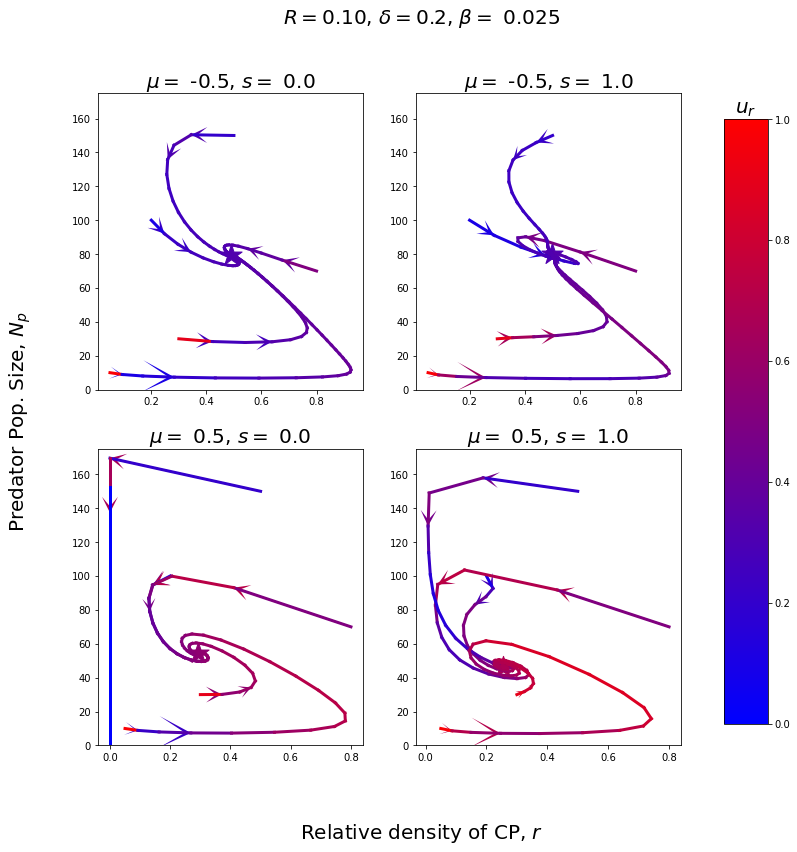

In [104]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
tsteps = 500
beta = 0.025
delta = 0.2
mu = -0.5
R = 0.1
s = 1.0


#make colorbar anchor
a = np.linspace(0,1,20)
b = np.linspace(0,1,20)
np.outer(a,b)
CS = plt.imshow(np.outer(a,b), cmap = cmap)
plt.clf()

fig, axs = plt.subplots(2,2, figsize = [12,12])
muvals = [-0.5,-0.5,0.5,0.5]
svals = [0,1,0,1]
for i, ax in enumerate(axs.flatten()):
    mu = muvals[i]
    s=svals[i]
    trajs, rhats,lambdas, mags = plot_Nru_traj(ax, R,delta,mu,s,beta,tsteps, cmap, minu=0, maxu=1, Nvals = [100,70,150,30],hl=10,hw=10)
    ts = r'$\mu=$ %.1f, $s=$ %.1f' %(mu,s)
    ax.set_title(ts, fontsize = 20)
    ax.set_ylim([0,175])
    
    # add another trajectory
    K = Kfun(s,scs.norm(mu)); pc = pcfun(s,scs.norm(mu))
    r = 0.05; N = 10; u_r = .98; x_r = 0; x_R = 0
    traj = get_trajectory(u_r, 1 - u_r, x_r,x_R,N,r,R,beta,delta,K,pc,tsteps)
    u_r_vec, u_R_vec, x_r_vec, x_R_vec, N_vec, r_vec, W = traj
    cs = plot_colourline(r_vec,N_vec,u_r_vec,minc=0,maxc=1,ax=ax, cmapAnchor=False, cmap = cmap,hl=20,hw=20)
    
    print(' r equilibria')
    print(rhats)
    print('eigenvalues')
    print(lambdas)
    print('magnitude of eigenvalues')
    print(mags)    
    


fig.supxlabel('Relative density of CP, $r$', fontsize = 20)
fig.supylabel('Predator Pop. Size, $N_p$', fontsize = 20)
ts = r'$R=$%.2f, $\delta=$%.1f, $\beta =$ %.3f' %(R,delta,beta)
fig.suptitle(ts, fontsize = 20)
# colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
cb = fig.colorbar(CS, cax = cbar_ax)
cb.ax.set_title(r'$u_r$', fontsize=20)
fig.savefig(fig_directory + '/Trajectories_R01_delta02_beta0025.jpg',dpi=600)

### $\beta = 1 \times 10^{-5}, \delta = 0.2, R = 0.1$

 r equilibria
[0.49022424        nan]
eigenvalues
[[3.700743415417188e-17, array(-0.26884706-0.10650667j), array(-0.26884706+0.10650667j)], []]
magnitude of eigenvalues
[array([3.70074342e-17, 2.89175395e-01, 2.89175395e-01]), []]
 r equilibria
[0.49695153        nan]
eigenvalues
[[0.7400486154839389, array(-0.7650064-0.28235392j), array(-0.7650064+0.28235392j)], []]
magnitude of eigenvalues
[array([0.74004862, 0.81544989, 0.81544989]), []]
 r equilibria
[0.29383881        nan]
eigenvalues
[[7.401486830834377e-17, array(-0.27238539-0.25132015j), array(-0.27238539+0.25132015j)], []]
magnitude of eigenvalues
[array([7.40148683e-17, 3.70615186e-01, 3.70615186e-01]), []]
 r equilibria
[0.25602483        nan]
eigenvalues
[[0.5419904502886781, array(-0.6606455-0.40536038j), array(-0.6606455+0.40536038j)], []]
magnitude of eigenvalues
[array([0.54199045, 0.77509323, 0.77509323]), []]


<Figure size 432x288 with 0 Axes>

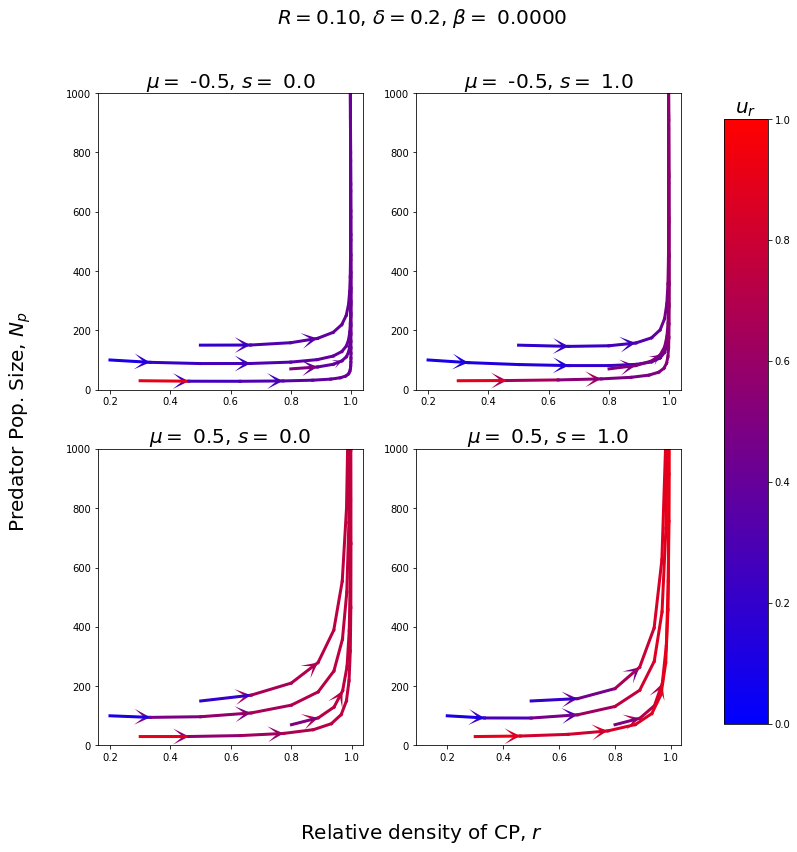

In [105]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
tsteps = 500
beta = 0.00001
delta = 0.2
R = 0.1


#make colorbar anchor
a = np.linspace(0,1,20)
b = np.linspace(0,1,20)
np.outer(a,b)
CS = plt.imshow(np.outer(a,b), cmap = cmap)
plt.clf()

fig, axs = plt.subplots(2,2, figsize = [12,12])
muvals = [-0.5,-0.5,0.5,0.5]
svals = [0,1,0,1]
for i, ax in enumerate(axs.flatten()):
    mu = muvals[i]
    s=svals[i]
    trajs, rhats,lambdas, mags = plot_Nru_traj(ax, R,delta,mu,s,beta,tsteps, cmap, minu=0, maxu=1, Nvals = [100,70,150,30],hl=10,hw=10)
    ts = r'$\mu=$ %.1f, $s=$ %.1f' %(mu,s)
    ax.set_title(ts, fontsize = 20)
    ax.set_ylim([0,1000])
    
    print(' r equilibria')
    print(rhats)
    print('eigenvalues')
    print(lambdas)
    print('magnitude of eigenvalues')
    print(mags)

fig.supxlabel('Relative density of CP, $r$', fontsize = 20)
fig.supylabel('Predator Pop. Size, $N_p$', fontsize = 20)
ts = r'$R=$%.2f, $\delta=$%.1f, $\beta =$ %.4f' %(R,delta,beta)
fig.suptitle(ts, fontsize = 20)
# colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
cb = fig.colorbar(CS, cax = cbar_ax)
cb.ax.set_title(r'$u_r$', fontsize=20)
fig.savefig(fig_directory + '/Trajectories_R01_delta02_beta00001.jpg',dpi=600)

### $\beta = 1E-5, \delta = 0.2, R = 0.1$

 r equilibria
[0.49022424        nan]
eigenvalues
[[3.700743415417188e-17, array(-0.26884706-0.10650667j), array(-0.26884706+0.10650667j)], []]
magnitude of eigenvalues
[array([3.70074342e-17, 2.89175395e-01, 2.89175395e-01]), []]
 r equilibria
[0.49695153        nan]
eigenvalues
[[0.7400486154839389, array(-0.7650064-0.28235392j), array(-0.7650064+0.28235392j)], []]
magnitude of eigenvalues
[array([0.74004862, 0.81544989, 0.81544989]), []]
 r equilibria
[0.29383881        nan]
eigenvalues
[[7.401486830834377e-17, array(-0.27238539-0.25132015j), array(-0.27238539+0.25132015j)], []]
magnitude of eigenvalues
[array([7.40148683e-17, 3.70615186e-01, 3.70615186e-01]), []]
 r equilibria
[0.25602483        nan]
eigenvalues
[[0.5419904502886781, array(-0.6606455-0.40536038j), array(-0.6606455+0.40536038j)], []]
magnitude of eigenvalues
[array([0.54199045, 0.77509323, 0.77509323]), []]


<Figure size 432x288 with 0 Axes>

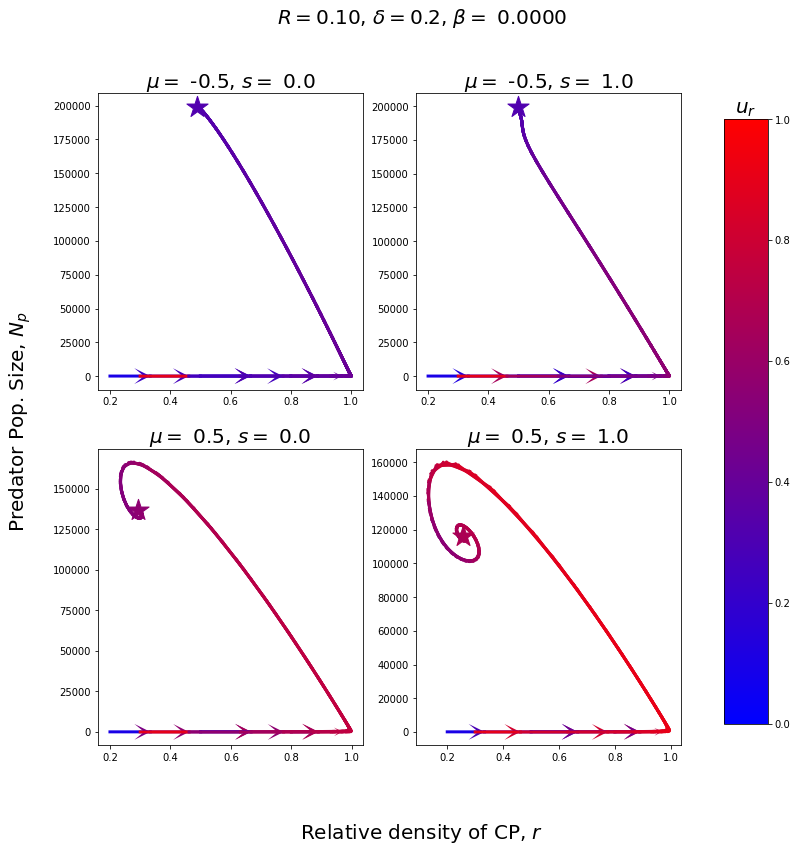

In [106]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
tsteps = 500
beta = 0.00001
delta = 0.2
R = 0.1


#make colorbar anchor
a = np.linspace(0,1,20)
b = np.linspace(0,1,20)
np.outer(a,b)
CS = plt.imshow(np.outer(a,b), cmap = cmap)
plt.clf()

fig, axs = plt.subplots(2,2, figsize = [12,12])
muvals = [-0.5,-0.5,0.5,0.5]
svals = [0,1,0,1]
for i, ax in enumerate(axs.flatten()):
    mu = muvals[i]
    s=svals[i]
    trajs, rhats,lambdas,mags = plot_Nru_traj(ax, R,delta,mu,s,beta,tsteps, cmap, minu=0, maxu=1, Nvals = [100,70,150,30],hl=10,hw=10)
    ts = r'$\mu=$ %.1f, $s=$ %.1f' %(mu,s)
    ax.set_title(ts, fontsize = 20)
    #ax.set_ylim([0,50000])
    
    print(' r equilibria')
    print(rhats)
    print('eigenvalues')
    print(lambdas)
    print('magnitude of eigenvalues')
    print(mags)

fig.supxlabel('Relative density of CP, $r$', fontsize = 20)
fig.supylabel('Predator Pop. Size, $N_p$', fontsize = 20)
ts = r'$R=$%.2f, $\delta=$%.1f, $\beta =$ %.4f' %(R,delta,beta)
fig.suptitle(ts, fontsize = 20)
# colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
cb = fig.colorbar(CS, cax = cbar_ax)
cb.ax.set_title(r'$u_r$', fontsize=20)
fig.savefig(fig_directory + '/Trajectories_R01_delta02_beta00001big.jpg',dpi=600)

## Plotting Trajectories for $R > \delta$

### $\beta = 0.025, \delta = 0.2, R = 0.21$

TypeError: ufunc 'cbrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

<Figure size 432x288 with 0 Axes>

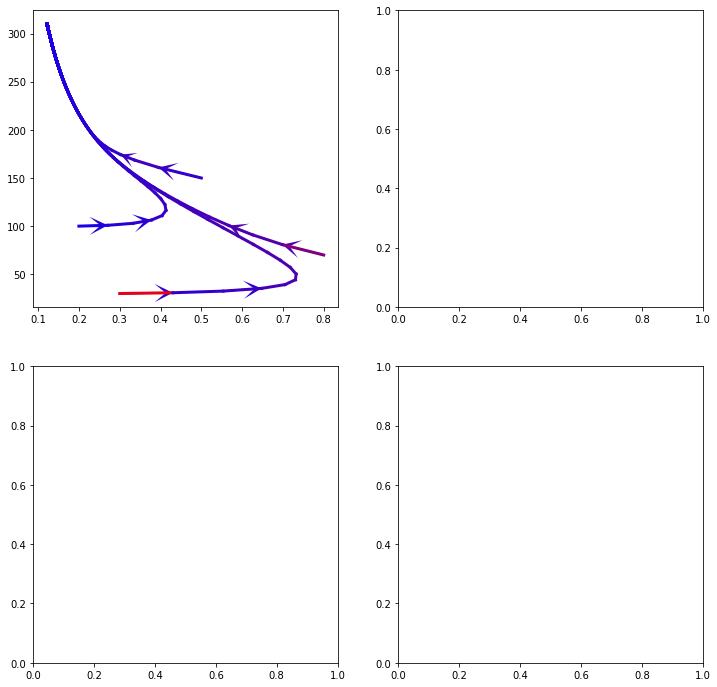

In [15]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
tsteps = 500
beta = 0.025
delta = 0.2
R = 0.21


#make colorbar anchor
a = np.linspace(0,1,20)
b = np.linspace(0,1,20)
np.outer(a,b)
CS = plt.imshow(np.outer(a,b), cmap = cmap)
plt.clf()

fig, axs = plt.subplots(2,2, figsize = [12,12])
muvals = [-0.5,-0.5,0.5,0.5]
svals = [0,1,0,1]
trajs_list = [0,0,0,0]
for i, ax in enumerate(axs.flatten()):
    mu = muvals[i]
    s=svals[i]
    trajs,rhats,lambdas = plot_Nru_traj(ax, R,delta,mu,s,beta,tsteps, cmap, minu=0, maxu=1, Nvals = [100,70,150,30],hl=10,hw=10)
    trajs_list[i] = trajs

    ts = r'$\mu=$ %.1f, $s=$ %.1f' %(mu,s)
    ax.set_title(ts, fontsize = 20)
    ax.set_ylim([0,800])
    K = Kfun(s,scs.norm(mu)); pc = pcfun(s,scs.norm(mu))
    r = 0.1; N = 500; u_r = 0.1; x_r = 0; x_R = 0
    traj = get_trajectory(u_r, 1 - u_r, x_r,x_R,N,r,R,beta,delta,K,pc,tsteps)
    u_r_vec, u_R_vec, x_r_vec, x_R_vec, N_vec, r_vec, W = traj
    cs = plot_colourline(r_vec,N_vec,u_r_vec,minc=0,maxc=1,ax=ax, cmapAnchor=False, cmap = cmap,hl=20,hw=20)
    

fig.supxlabel('Relative density of CP, $r$', fontsize = 20)
fig.supylabel('Predator Pop. Size, $N_p$', fontsize = 20)
ts = r'$R=$%.2f, $\delta=$%.1f, $\beta =$ %.3f' %(R,delta,beta)
fig.suptitle(ts, fontsize = 20)
# colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
cb = fig.colorbar(CS, cax = cbar_ax)
cb.ax.set_title(r'$u_r$', fontsize=20)
fig.savefig(fig_directory + '/Trajectories_R021_delta02_beta0025.jpg',dpi=600)

In [42]:
Nhat=get_N_hat(rhats[1],delta,R,beta)

In [43]:
Nhat

753.6622186401513

In [224]:
u_r_vecs = [traj[0] for traj in trajs]
N_vecs = [traj[4] for traj in trajs]
r_vecs = [traj[-2] for traj in trajs]

In [225]:
u_last = [vec[-1] for vec in u_r_vecs]
N_last = [vec[-1] for vec in N_vecs]
r_last = [vec[-1] for vec in r_vecs]

In [227]:
N_last

[5210.558007562199, 5148.586147695389, 5644.266408002985, 4770.881848910831]

### $\beta = 0.025, \delta = 0.2, R = 0.4$

<Figure size 432x288 with 0 Axes>

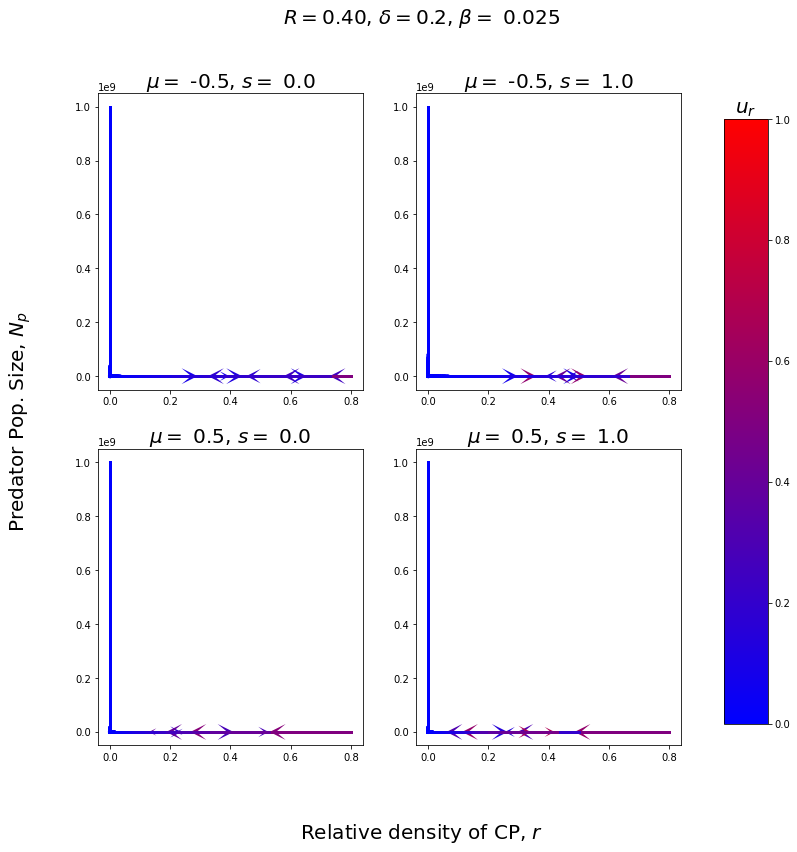

In [16]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
tsteps = 500
beta = 0.025
delta = 0.2
R = 0.4


#make colorbar anchor
a = np.linspace(0,1,20)
b = np.linspace(0,1,20)
np.outer(a,b)
CS = plt.imshow(np.outer(a,b), cmap = cmap)
plt.clf()

fig, axs = plt.subplots(2,2, figsize = [12,12])
muvals = [-0.5,-0.5,0.5,0.5]
svals = [0,1,0,1]
trajs_list = [0]*4
for i, ax in enumerate(axs.flatten()):
    mu = muvals[i]
    s=svals[i]
    trajs,rhats,lambdas,mags = plot_Nru_traj(ax, R,delta,mu,s,beta,tsteps, cmap, minu=0, maxu=1, Nvals = [100,70,150,30],hl=10,hw=10)
    trajs_list[i] = trajs
    ts = r'$\mu=$ %.1f, $s=$ %.1f' %(mu,s)
    ax.set_title(ts, fontsize = 20)


fig.supxlabel('Relative density of CP, $r$', fontsize = 20)
fig.supylabel('Predator Pop. Size, $N_p$', fontsize = 20)
ts = r'$R=$%.2f, $\delta=$%.1f, $\beta =$ %.3f' %(R,delta,beta)
fig.suptitle(ts, fontsize = 20)
# colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
cb = fig.colorbar(CS, cax = cbar_ax)
cb.ax.set_title(r'$u_r$', fontsize=20)
fig.savefig(fig_directory + '/Trajectories_R04_delta02_beta0025.jpg',dpi=600)

In [238]:
trajs = trajs_list[1]
u_r_lasts = [[traj[0][-1] for traj in trajs] for trajs in trajs_list]
N_lasts = [[traj[4][-1] for traj in trajs] for trajs in trajs_list]
r_lasts = [[traj[-2][-1] for traj in trajs] for trajs in trajs_list]

In [239]:
N_lasts

[[1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0],
 [1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0],
 [1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0],
 [1000000000.0, 1000000000.0, 1000000000.0, 981945010.8732337]]

In [232]:
trajs_list[3]

[(array([0.1       , 0.21158395, 0.30410839, 0.36286396, 0.38296659,
         0.37267963, 0.34809622, 0.32365313, 0.30710022, 0.30032944,
         0.3018467 , 0.3087139 , 0.3177957 , 0.32653296, 0.33334542,
         0.33769099, 0.33984643, 0.34054118, 0.34059499, 0.34066526,
         0.34113612, 0.34212391, 0.34355027, 0.34523644, 0.34698692,
         0.3486457 , 0.35012174, 0.3513886 , 0.35246789, 0.3534066 ,
         0.35425641, 0.35505941, 0.3558416 , 0.35661283, 0.35737083,
         0.3581068 , 0.35881052, 0.359474  , 0.36009311, 0.3606677 ,
         0.36120062, 0.36169638, 0.36215977, 0.36259503, 0.36300531,
         0.36339271, 0.36375844, 0.3641032 , 0.36442749, 0.36473189,
         0.36501712, 0.36528414, 0.36553403, 0.36576794, 0.365987  ,
         0.36619228, 0.36638472, 0.36656515, 0.36673432, 0.36689288,
         0.36704144, 0.36718059, 0.36731087, 0.36743283, 0.36754698,
         0.36765382, 0.36775381, 0.36784741, 0.36793501, 0.36801701,
         0.36809375, 0.36816558, 0

### $\beta = 0.025, \delta = 0.2, R = 0.4$

In [ ]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
tsteps = 10
beta = 0.025
delta = 0.2
R = 0.4


#make colorbar anchor
a = np.linspace(0,1,20)
b = np.linspace(0,1,20)
np.outer(a,b)
CS = plt.imshow(np.outer(a,b), cmap = cmap)
plt.clf()

fig, axs = plt.subplots(2,2, figsize = [12,12])
muvals = [-0.5,-0.5,0.5,0.5]
svals = [0,1,0,1]
trajs_list = [0]*4
for i, ax in enumerate(axs.flatten()):
    mu = muvals[i]
    s=svals[i]
    trajs = plot_Nru_traj(ax, R,delta,mu,s,beta,tsteps, cmap, minu=0, maxu=1, Nvals = [100,70,150,30],hl=10,hw=10)
    trajs_list[i] = trajs
    ts = r'$\mu=$ %.1f, $s=$ %.1f' %(mu,s)
    ax.set_title(ts, fontsize = 20)


fig.supxlabel('Relative density of CP, $r$', fontsize = 20)
fig.supylabel('Predator Pop. Size, $N_p$', fontsize = 20)
ts = r'$R=$%.2f, $\delta=$%.1f, $\beta =$ %.3f' %(R,delta,beta)
fig.suptitle(ts, fontsize = 20)
# colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85,0.15,0.05,0.7])
cb = fig.colorbar(CS, cax = cbar_ax)
cb.ax.set_title(r'$u_r$', fontsize=20)
fig.savefig(fig_directory + '/Trajectories_R04_delta02_beta0025t10.jpg',dpi=600)

# Trajectories with time on Horizontal Axis

In [67]:
None == None

True

In [6]:
def plot_time_traj(ax1, tsteps,u_r_vec,r_vec,N_vec,y1lim = None, y2lim = 1):
    t = np.arange(0,tsteps,1)

    ax1.set_xlabel('time (generations)')
    ax1.set_ylabel('Predator Population Size')
    ax1.plot(t,N_vec)
    if y1lim != None:
        ax1.set_ylim([0,y1lim])

    ax1b = ax1.twinx()
    ax1b.set_ylabel(r'Frequency ($u_r$ or $r$)')
    ax1b.plot(t,r_vec, color = 'r')
    ax1b.plot(t,u_r_vec, color = 'purple')
    ax1b.set_ylim([0,y2lim])
    return(1)

## $\beta = 0.05, \delta = 0.2, R = 0.1$

### $\mu = -0.5, s = 1$

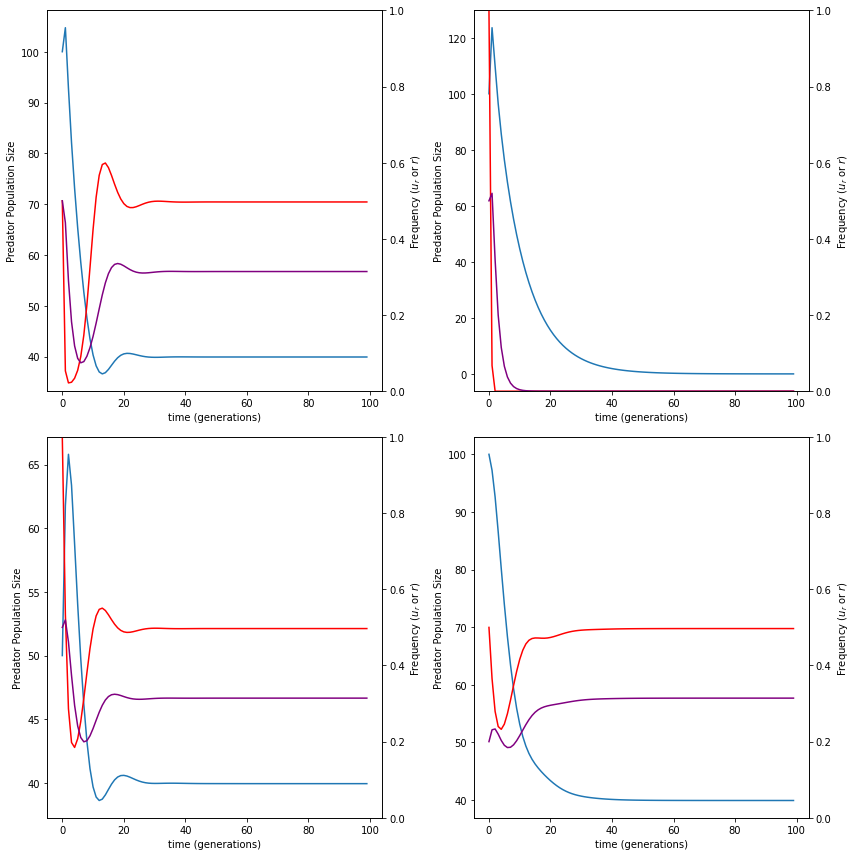

In [7]:

# ecological parameters 
beta = 0.05
delta = 0.2
#mu = -0.5
R = 0.1

# learning parameters
s = 1.0
mu = -0.5
K = Kfun(s,scs.norm(mu))
pc = pcfun(s,scs.norm(mu))


tsteps = 100

fig, axes = plt.subplots(2,2, figsize = (12,12))

x_r = 0; x_R = 0



# trajectory 1
N = 100
u_r = 0.5
r = 0.5

traj = get_trajectory(u_r, 1 - u_r, x_r,x_R,N,r,R,beta,delta,K,pc,tsteps)
u_r_vec, _, _, _, N_vec, r_vec, _ = traj
plot_time_traj(axes.flatten()[0],tsteps,u_r_vec,r_vec,N_vec)


# trajectory 2
N = 100
u_r = 0.5
r = 1.0

traj = get_trajectory(u_r, 1 - u_r, x_r,x_R,N,r,R,beta,delta,K,pc,tsteps)
u_r_vec, _, _, _, N_vec, r_vec, _ = traj
plot_time_traj(axes.flatten()[1],tsteps,u_r_vec,r_vec,N_vec)

# trajectory 3
N = 50
u_r = 0.5
r = 1.0

traj = get_trajectory(u_r, 1 - u_r, x_r,x_R,N,r,R,beta,delta,K,pc,tsteps)
u_r_vec, _, _, _, N_vec, r_vec, _ = traj
plot_time_traj(axes.flatten()[2],tsteps,u_r_vec,r_vec,N_vec)

# trajectory 4
N = 100
u_r = 0.2
r = 0.5

traj = get_trajectory(u_r, 1 - u_r, x_r,x_R,N,r,R,beta,delta,K,pc,tsteps)
u_r_vec, _, _, _, N_vec, r_vec, _ = traj
plot_time_traj(axes.flatten()[3],tsteps,u_r_vec,r_vec,N_vec)



fig.tight_layout()
fig.savefig(fig_directory + '/Trajectories_R01_delta02_beta005_muNeg05_s1time.jpg',dpi=600)

### $\mu = -0.5, s = 0$

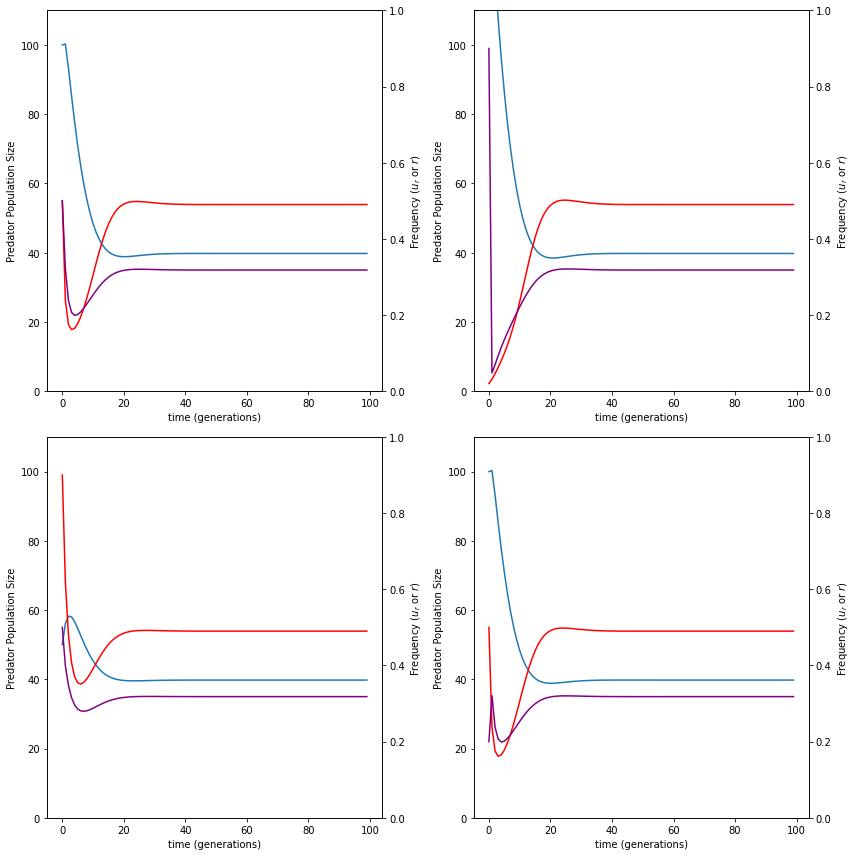

In [8]:

# ecological parameters 
beta = 0.05
delta = 0.2
#mu = -0.5
R = 0.1

# learning parameters
s = 0
mu = -0.5
K = Kfun(s,scs.norm(mu))
pc = pcfun(s,scs.norm(mu))


tsteps = 100

fig, axes = plt.subplots(2,2, figsize = (12,12))

x_r = 0; x_R = 0



# trajectory 1
N = 100
u_r = 0.5
r = 0.5



y1lim = 110
traj = get_trajectory(u_r, 1 - u_r, x_r,x_R,N,r,R,beta,delta,K,pc,tsteps)
u_r_vec, _, _, _, N_vec, r_vec, _ = traj
plot_time_traj(axes.flatten()[0],tsteps,u_r_vec,r_vec,N_vec,y1lim=y1lim)


# trajectory 2
N = 150
u_r = 0.9
r = 0.02

traj = get_trajectory(u_r, 1 - u_r, x_r,x_R,N,r,R,beta,delta,K,pc,tsteps)
u_r_vec, _, _, _, N_vec, r_vec, _ = traj
plot_time_traj(axes.flatten()[1],tsteps,u_r_vec,r_vec,N_vec,y1lim=y1lim)

# trajectory 3
N = 50
u_r = 0.5
r = 0.9

traj = get_trajectory(u_r, 1 - u_r, x_r,x_R,N,r,R,beta,delta,K,pc,tsteps)
u_r_vec, _, _, _, N_vec, r_vec, _ = traj
plot_time_traj(axes.flatten()[2],tsteps,u_r_vec,r_vec,N_vec,y1lim=y1lim)

# trajectory 4
N = 100
u_r = 0.2
r = 0.5

traj = get_trajectory(u_r, 1 - u_r, x_r,x_R,N,r,R,beta,delta,K,pc,tsteps)
u_r_vec, _, _, _, N_vec, r_vec, _ = traj
plot_time_traj(axes.flatten()[3],tsteps,u_r_vec,r_vec,N_vec,y1lim=y1lim)



fig.tight_layout()
fig.savefig(fig_directory + '/Trajectories_R01_delta02_beta005_muPos05_s0time.jpg',dpi=600)

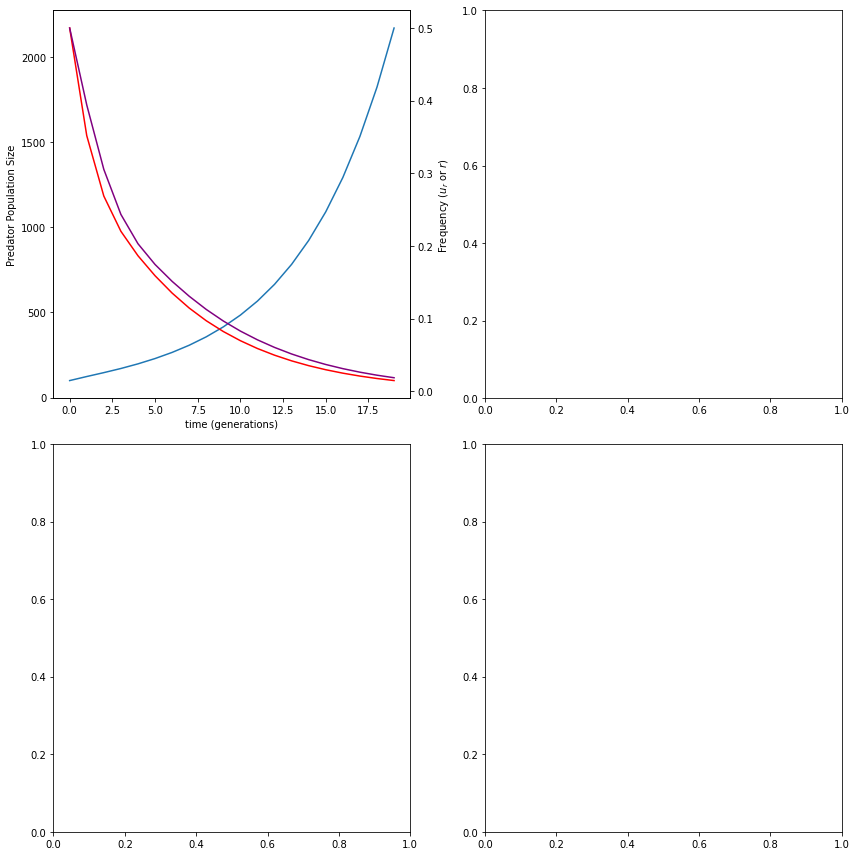

In [54]:
beta = 0.025
delta = 0.2
R = 0.4

K = 0.2
pc = 0.5


fig, axes = plt.subplots(2,2, figsize = (12,12))



# trajectory 1

tsteps = 20 # note: choose tsteps so we stop before N goes to 1 billion
# initial conditions
N = 100
u_r = 0.5
r = 0.5
x_r = 0; x_R = 0

traj = get_trajectory(u_r, 1 - u_r, x_r,x_R,N,r,R,beta,delta,K,pc,tsteps)
u_r_vec, _, _, _, N_vec, r_vec, _ = traj




plot_time_traj(axes.flatten()[0],tsteps,u_r_vec,r_vec,N_vec)
fig.tight_layout()

1

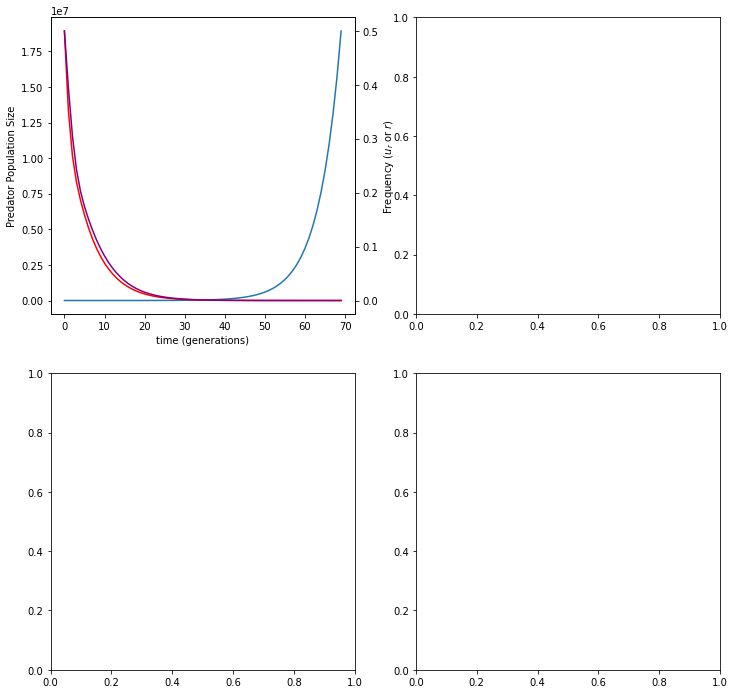